NEURAL NETWORK SURROGATE MODEL
Argon ICP Thruster - 0D Global Model
Using scikit-learn MLPRegressor

Loading training data...
Loaded 6420 training samples
Input range: Power [200, 1600] W, Pressure [1.0, 6.0] mTorr


Training samples: 5136
Validation samples: 1284

Training started...
Iteration 1, loss = 0.02884575
Validation score: 0.996932
Iteration 2, loss = 0.00231225
Validation score: 0.999358
Iteration 3, loss = 0.00215424
Validation score: 0.998933
Iteration 4, loss = 0.00227627
Validation score: 0.995526
Iteration 5, loss = 0.00204221
Validation score: 0.997965
Iteration 6, loss = 0.00175956
Validation score: 0.999056
Iteration 7, loss = 0.00206043
Validation score: 0.998042
Iteration 8, loss = 0.00226474
Validation score: 0.997339
Iteration 9, loss = 0.00193488
Validation score: 0.998990
Iteration 10, loss = 0.00204470
Validation score: 0.999384
Iteration 11, loss = 0.00194648
Validation score: 0.999530
Iteration 12, loss = 0.00142307
Validation score: 0.999811
Iteration 13, l

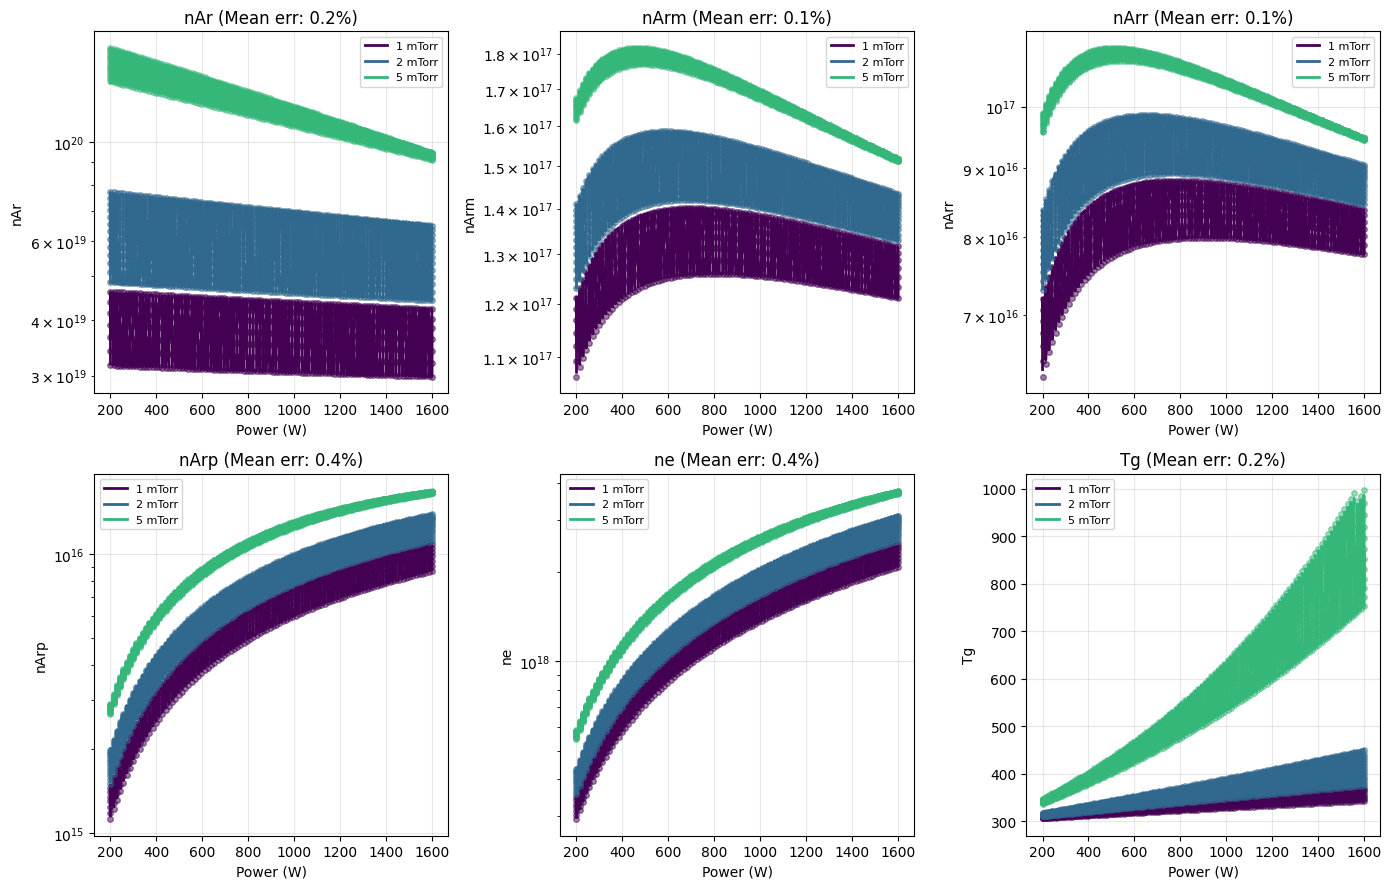

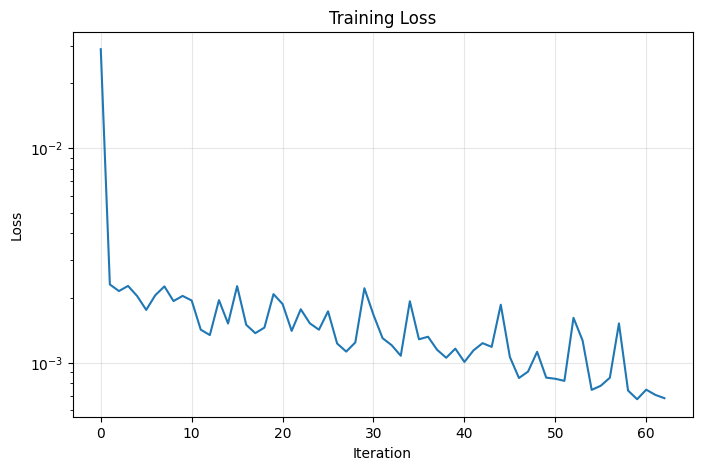

Model saved to plasma_surrogate_model.pkl

COMPLETE!
Files created:
  - plasma_surrogate_model.pkl (trained model)
  - plasma_surrogate_summary.json (model summary)
  - nn_surrogate_evaluation.png (evaluation plots)
  - nn_training_history.png (training history)


In [1]:
"""
nn_surrogate_sklearn.py
=======================
Neural Network Surrogate Model for Argon ICP Thruster
Using scikit-learn MLPRegressor (no PyTorch required)

Inputs: Power, Pressure
Outputs: nAr, nArm, nArr, nArp, ne, Tg (6 outputs)

NOTE: Te is excluded because the 0D model has known limitations
at high power. Te should be handled separately using reference data.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import json

# Set random seed
np.random.seed(42)


def load_training_data(csv_path='nn_training_data.csv'):
    """Load training data from MATLAB export."""
    df = pd.read_csv(csv_path)
    
    # Inputs
    X = df[['Power_W', 'Pressure_mTorr']].values
    
    # Outputs (excluding Te_model)
    Y = df[['nAr', 'nArm', 'nArr', 'nArp', 'ne', 'Tg']].values
    
    print(f"Loaded {len(X)} training samples")
    print(f"Input range: Power [{X[:,0].min():.0f}, {X[:,0].max():.0f}] W, "
          f"Pressure [{X[:,1].min():.1f}, {X[:,1].max():.1f}] mTorr")
    
    return X, Y, df


class PlasmaSurrogate:
    """
    Neural network surrogate for the 0D global plasma model.
    Uses scikit-learn MLPRegressor.
    
    Inputs (2):
        - Power [W]
        - Pressure [mTorr]
    
    Outputs (6):
        - nAr: Ground state Ar density [m^-3]
        - nArm: Metastable Ar density [m^-3]
        - nArr: Resonant Ar density [m^-3]
        - nArp: 4p state Ar density [m^-3]
        - ne: Electron density [m^-3]
        - Tg: Gas temperature [K]
    """
    
    def __init__(self, hidden_layers=(128, 256, 128, 64)):
        self.hidden_layers = hidden_layers
        self.scaler_X = StandardScaler()
        self.scaler_Y = StandardScaler()
        self.model = None
        self.output_names = ['nAr', 'nArm', 'nArr', 'nArp', 'ne', 'Tg']
        
    def prepare_data(self, X, Y):
        """Prepare and transform data."""
        # Log-transform densities (first 5 columns)
        Y_transformed = Y.copy()
        Y_transformed[:, :5] = np.log10(Y[:, :5] + 1e-10)
        
        # Fit scalers
        X_scaled = self.scaler_X.fit_transform(X)
        Y_scaled = self.scaler_Y.fit_transform(Y_transformed)
        
        return X_scaled, Y_scaled
    
    def train(self, X, Y, test_size=0.2, max_iter=2000, verbose=True):
        """Train the neural network."""
        
        # Prepare data
        X_scaled, Y_scaled = self.prepare_data(X, Y)
        
        # Split data
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_scaled, Y_scaled, test_size=test_size, random_state=42
        )
        
        print(f"\nTraining samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        
        # Create and train model
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layers,
            activation='relu',
            solver='adam',
            alpha=0.0001,  # L2 regularization
            batch_size=32,
            learning_rate='adaptive',
            learning_rate_init=0.001,
            max_iter=max_iter,
            shuffle=True,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=50,
            verbose=verbose
        )
        
        print("\nTraining started...")
        print("=" * 60)
        
        self.model.fit(X_train, Y_train)
        
        print("=" * 60)
        print(f"Training complete! Iterations: {self.model.n_iter_}")
        
        # Evaluate on validation set
        Y_val_pred = self.model.predict(X_val)
        val_score = self.model.score(X_val, Y_val)
        print(f"Validation R² score: {val_score:.4f}")
        
        return self.model.loss_curve_
    
    def predict(self, X):
        """Make predictions."""
        X_scaled = self.scaler_X.transform(X)
        Y_pred_scaled = self.model.predict(X_scaled)
        
        # Inverse transform
        Y_pred_transformed = self.scaler_Y.inverse_transform(Y_pred_scaled)
        
        # Un-log densities
        Y_pred = Y_pred_transformed.copy()
        Y_pred[:, :5] = 10 ** Y_pred_transformed[:, :5]
        
        return Y_pred
    
    def evaluate(self, X, Y):
        """Evaluate model performance."""
        Y_pred = self.predict(X)
        
        # Calculate relative errors
        errors = np.abs(Y_pred - Y) / Y * 100
        
        results = {}
        print("\n" + "=" * 60)
        print("MODEL EVALUATION")
        print("=" * 60)
        print(f"{'Output':<8} {'Mean Err %':<12} {'Max Err %':<12} {'R²':<10}")
        print("-" * 45)
        
        for i, name in enumerate(self.output_names):
            mean_err = errors[:, i].mean()
            max_err = errors[:, i].max()
            r2 = r2_score(Y[:, i], Y_pred[:, i])
            
            print(f"{name:<8} {mean_err:<12.2f} {max_err:<12.2f} {r2:<10.4f}")
            
            results[name] = {
                'mean_error': mean_err,
                'max_error': max_err,
                'r2': r2
            }
        
        print("=" * 60)
        
        return errors, results
    
    def save(self, filepath):
        """Save model and scalers."""
        data = {
            'model': self.model,
            'scaler_X': self.scaler_X,
            'scaler_Y': self.scaler_Y,
            'hidden_layers': self.hidden_layers,
            'output_names': self.output_names
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Model saved to {filepath}")
    
    def load(self, filepath):
        """Load model and scalers."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.model = data['model']
        self.scaler_X = data['scaler_X']
        self.scaler_Y = data['scaler_Y']
        self.hidden_layers = data['hidden_layers']
        self.output_names = data['output_names']
        print(f"Model loaded from {filepath}")


def plot_results(surrogate, X, Y, df):
    """Create visualization of results."""
    
    Y_pred = surrogate.predict(X)
    errors = np.abs(Y_pred - Y) / Y * 100
    
    # Get unique pressures for plotting
    pressures = [1, 2, 5, 10]
    colors = plt.cm.viridis(np.linspace(0, 1, len(pressures)))
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    
    for idx, (ax, name) in enumerate(zip(axes.flatten(), surrogate.output_names)):
        for p_idx, p in enumerate(pressures):
            mask = np.abs(df['Pressure_mTorr'].values - p) < 0.5
            if mask.sum() > 0:
                power = X[mask, 0]
                y_true = Y[mask, idx]
                y_pred = Y_pred[mask, idx]
                
                sort_idx = np.argsort(power)
                ax.plot(power[sort_idx], y_true[sort_idx], 'o', color=colors[p_idx], 
                        markersize=4, alpha=0.5)
                ax.plot(power[sort_idx], y_pred[sort_idx], '-', color=colors[p_idx],
                        linewidth=2, label=f'{p} mTorr')
        
        ax.set_xlabel('Power (W)')
        ax.set_ylabel(name)
        ax.set_title(f'{name} (Mean err: {errors[:,idx].mean():.1f}%)')
        if idx < 5:  # Log scale for densities
            ax.set_yscale('log')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('nn_surrogate_evaluation.png', dpi=150)
    plt.show()
    
    # Training loss plot
    if hasattr(surrogate.model, 'loss_curve_'):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.semilogy(surrogate.model.loss_curve_)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss')
        ax.grid(True, alpha=0.3)
        plt.savefig('nn_training_history.png', dpi=150)
        plt.show()


def main():
    """Main function to train and evaluate NN surrogate."""
    
    print("=" * 60)
    print("NEURAL NETWORK SURROGATE MODEL")
    print("Argon ICP Thruster - 0D Global Model")
    print("Using scikit-learn MLPRegressor")
    print("=" * 60)
    print()
    
    # Load data
    print("Loading training data...")
    try:
        X, Y, df = load_training_data('nn_training_data.csv')
    except FileNotFoundError:
        print("ERROR: nn_training_data.csv not found!")
        print("Run generate_nn_training_data.m in MATLAB first.")
        return
    print()
    
    # Create surrogate
    surrogate = PlasmaSurrogate(hidden_layers=(256, 512, 512, 256))
    
    # Train
    loss_curve = surrogate.train(X, Y, max_iter=5000, verbose=True)
    print()
    
    # Evaluate
    errors, results = surrogate.evaluate(X, Y)
    
    # Plot
    plot_results(surrogate, X, Y, df)
    
    # Save model
    surrogate.save('plasma_surrogate_model.pkl')
    
    # Save summary
    summary = {
        'inputs': ['Power_W', 'Pressure_mTorr'],
        'outputs': surrogate.output_names,
        'input_ranges': {
            'Power_W': [float(X[:,0].min()), float(X[:,0].max())],
            'Pressure_mTorr': [float(X[:,1].min()), float(X[:,1].max())]
        },
        'mean_errors_percent': {name: results[name]['mean_error'] for name in surrogate.output_names},
        'max_errors_percent': {name: results[name]['max_error'] for name in surrogate.output_names},
        'r2_scores': {name: results[name]['r2'] for name in surrogate.output_names},
        'note': 'Te excluded due to 0D model limitations at high power'
    }
    
    with open('plasma_surrogate_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("\n" + "=" * 60)
    print("COMPLETE!")
    print("Files created:")
    print("  - plasma_surrogate_model.pkl (trained model)")
    print("  - plasma_surrogate_summary.json (model summary)")
    print("  - nn_surrogate_evaluation.png (evaluation plots)")
    print("  - nn_training_history.png (training history)")
    print("=" * 60)


if __name__ == "__main__":
    main()